In [2]:
import tensorflow as tf
import numpy as np
import glob
import cv2
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def plotPoke(x):
    f, a = plt.subplots(2, 8, figsize=(8, 2))
    for i in range(8):
        a[0][i].imshow(x[i], cmap=plt.get_cmap('gray'))
        a[0,i].axis('off')
        a[1][i].imshow(x[i+8], cmap=plt.get_cmap('gray'))
        a[1,i].axis('off')
    f.show()
    plt.draw()

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


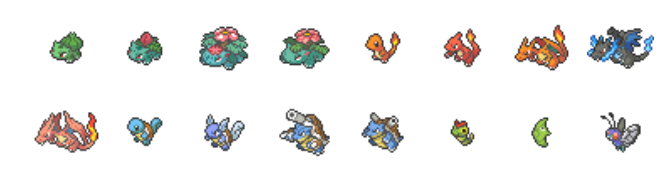

In [5]:
# Create an empty array to store pokemon pics
orig_img = np.empty((0, 40, 40,3), dtype='float32')
# Load all images and append into orig_img
path = os.path.abspath("./VAE.ipynb")
path = re.sub('[a-zA-Z\s._]+$', '', path)
for pic in glob.glob(path+'Pokemon/*.png'):
    img = mpimg.imread(pic)
    # remove alpha channel  %some alpha=0 but RGB is not equal to [1., 1., 1.]
    img[img[:,:,3]==0] = np.ones((1,4))
    img = img[:,:,:3]
    orig_img = np.append(orig_img, [img], axis=0)

# Use plt to show original images 
plotPoke(orig_img)

In [6]:
# Transpose RGB channels into 3 different independent image
# Then flatted all pixel into one dimension
X_flat = np.transpose(orig_img, (0,3,1,2))
X_flat = X_flat.reshape(2376, 1600)

print 'Original image shape:  {0}\nFlatted image shape:  {1}'.format(orig_img.shape, X_flat.shape)

Original image shape:  (792, 40, 40, 3)
Flatted image shape:  (2376, 1600)


In [57]:
# Parameters
learning_rate = 0.01
training_epochs = 1000
batch_size = 24
display_step = 20
examples_to_show = 8
l2_lambda = 0 # regularization weight

# Network Parameters
n_hidden_1 = 1024
n_hidden_2 = 512
n_latent = 40
n_input = 1600 # Pokemon input (img shape: 40*40)

In [58]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev=0.01)),
    'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.01)),
    'hidden_mu' : tf.Variable(tf.truncated_normal([n_hidden_2, n_latent], stddev=0.01)),
    'hidden_sig': tf.Variable(tf.truncated_normal([n_hidden_2, n_latent], stddev=0.01)),
    'decoder_h1': tf.Variable(tf.truncated_normal([n_latent, n_hidden_2], stddev=0.01)),    
    'decoder_h2': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1], stddev=0.01)),
    'decoder_h3': tf.Variable(tf.truncated_normal([n_hidden_1, n_input], stddev=0.01))
}
biases = {
    'encoder_b1': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=0.01)),
    'encoder_b2': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=0.01)),
    'hidden_mu' : tf.Variable(tf.truncated_normal([n_latent], stddev=0.01)),
    'hidden_sig': tf.Variable(tf.truncated_normal([n_latent], stddev=0.01)),
    'decoder_b1': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=0.01)),
    'decoder_b2': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=0.01)),
    'decoder_b3': tf.Variable(tf.truncated_normal([n_input], stddev=0.01))
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2

# Building the variational
def variation(x):
    mu = tf.add(tf.matmul(x, weights['hidden_mu']), biases['hidden_mu'])
    sig = tf.add(tf.matmul(x, weights['hidden_sig']), biases['hidden_sig'])
    
    layer_mu = tf.nn.sigmoid(mu)
    layer_sig = tf.nn.sigmoid(sig)
    epsilon = tf.random_normal(tf.shape(layer_sig), stddev=0.001, name='epsilon')
    layer_latent = tf.add(layer_mu, tf.mul(tf.exp(0.5*layer_sig), epsilon))

    KLD = -0.5 * tf.reduce_sum(1+sig-tf.pow(mu, 2)-tf.exp(sig), reduction_indices=1)

    return layer_latent, KLD

# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']))
    return layer_3

In [59]:
# Construct model
encoder_op = encoder(X)
variation_op, KLD = variation(encoder_op)
decoder_op = decoder(variation_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer
l2_loss = tf.add_n([tf.nn.l2_loss(weights[w]) for w in weights])
BCE = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(y_pred, y_true), reduction_indices=1)

cost = tf.reduce_mean(BCE+KLD)+l2_lambda*l2_loss
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [60]:
sess = tf.InteractiveSession()
sess.run(init)
total_batch = int(X_flat.shape[0]/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    start = 0; end = batch_size-1
    for i in range(total_batch):
        index = np.arange(start, end)
        np.random.shuffle(index)
        batch_xs = X_flat[index]
        start = end+1; end = start+batch_size-1
        # Run optimization op (backprop) and loss op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if ((epoch == 0) or (epoch+1) % display_step == 0) or ((epoch+1) == training_epochs):
        print 'Epoch: {0:04d}   loss: {1:f}'.format(epoch+1, c)

print("Optimization Finished!")

Epoch: 0001   loss: 715.691223
Epoch: 0020   loss: 710.296265
Epoch: 0040   loss: 710.352356
Epoch: 0060   loss: 710.642273
Epoch: 0080   loss: 710.807373
Epoch: 0100   loss: 710.721375
Epoch: 0120   loss: 710.496155
Epoch: 0140   loss: 710.379272


KeyboardInterrupt: 

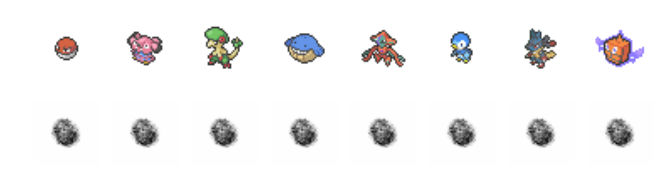

In [61]:
# Random select some pokemon to visualization
# index are picked in orig_img.shape[0], then transform to X_flat with correspond RGB row
index = np.random.randint(orig_img.shape[0], size=examples_to_show)
index = np.concatenate((index, index+1, index+2))
index = np.sort(index)
autoencoder = sess.run(
    y_pred, feed_dict={X: X_flat[index]})

# merge RGB rows back to RGB matrix
autoencoder = np.reshape(autoencoder, (examples_to_show, 3, 40, 40))
autoencoder = np.transpose(autoencoder, (0,2,3,1))

# Compare original images with their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(orig_img[index[::3][i]])
    a[0,i].axis('off')
    a[1][i].imshow(autoencoder[i])
    a[1,i].axis('off')
f.show()
plt.draw()